### 🖋 **Notebook Contents**

0. Initial Setup
1. Business Problem Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Conclusion
6. Recommendation

****

## `Initial Setup`

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import lines, patches
import plotly.express as px

from sklearn.model_selection import train_test_split # splitting data
from sklearn.decomposition import PCA # visualisasi cluster
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, MinMaxScaler # untuk encoder dan scaling
import category_encoders as ce # untuk encoder
from sklearn.cluster import DBSCAN # untuk cek outlier
from sklearn.metrics import silhouette_score, calinski_harabasz_score # metric evaluasi untuk clustering
from sklearn.base import BaseEstimator, TransformerMixin # membuat class untuk PreproccesDataset

# column transformer untuk Pycaret
from pycaret.internal.preprocess.transformers import TransformerWrapper

# my own function
import function as fnk

import warnings
warnings.filterwarnings("ignore")

## `Business Problem`

<h1><center> <span style="color:#0ad0f7">Hotel Booking Demand</span></center></h1>

**Context**:
<br>
Terdapat sebuah perusahaan yang bergerak dibidang hospitality industry-khususnya perhotelan-dan berlokasi di Portugal, memiliki dataset yang telah diekstrak dari database hotel (Property Management System (PMS)). Hospitality industry lebih fokus dengan kepuasan pelanggan. Berdasarkan [The Big Four](https://www.hospitalitynet.org/opinion/4082318.html), ada bermacam-macam hospitality industry, seperti Food and Beverages, Travel and Tourism, Lodging, dan Recreation. Industri hotel termasuk ke dalam lodging, salah satu permasalahan yang sering terjadi pada industri hotel adalah pembatalan pesanan oleh pelanggan. Salah satu cara pemesanan kamar pada perusahaan hotel ini adalah dengan melakukan pemesanan terlebih dahulu sebelum tanggal menginap (booking system).

Target (is_canceled):

1 : pesanan yang dibatalkan (positif)

0 : pesanan yang **tidak** dibatalkan (negatif)

**Project Stakeholders**:
<br>
Stakeholders yang akan menggunakan model ini adalah:
1. Marketing & Sales Departement : Departement ini bertanggungjawab untuk memaksimalkan revenue dengan cara melakukan beberapa strategi marketing (ex: promosi/diskon) kepada pelanggan, sehingga dengan model ini Marketing dan Sales Departement bisa mengetahui pelanggan yang **tepat** untuk diberi promosi/diskon.
2. Finance Departement : Salah satu tugas Finance Departement adalah mengatur pemasukan dan pengeluaran keuangan perusahaan yang salah satunya diakibatkan dari promosi/campaign yang diadakan Marketing dan Sales Departement. 

Pada dasarnya, kedua departement ini saling berkesinambungan dan memiliki pertanyaan/tujuan yang sama, yaitu **bagaimana caranya memaksimalkan revenue perusahaan.**

**Prolem Statement**:
<br>
Ada beberapa problem yang sering terjadi di hotel industry, salah satunya adalah pembatalan pesanan yang telah dilakukan. Berdasarkan referensi dibawah, cancellation rate secara global berada pada angka **33%** pada tahun 2014 dan **40%** pada tahun 2018, sedangkan pada dataset ini cancellation rate-nya sebesar **37%**. Hal ini menunjukkan adanya peningkatan cancellation rate pada tahun-tahun tersebut dan tentu saja memberikan dampak **negatif** bagi revenue perusahaan. Revenue loss akibat dari pesanan yang dibatalkan dapat mencapai **15%**.

Sampai saat ini pihak hotel masih melakukan prediksi pembatalan pesanan dengan cara manual, sehingga penawaran/marketing yang dilakukan kurang tepat sasaran. Hal ini tentu berdampak bagi pihak hotel pada tidak maksimalnya revenue yang didapatkan. 

Reference:
1. [Global Cancellation Rate Hotel Reservations Reacehs 40 average](https://hospitalitytech.com/global-cancellation-rate-hotel-reservations-reaches-40-average)
2. [How Hotels Can Combat Rising Cancellation Rates](https://resources.emerchantpay.com/how-hotels-can-combat-rising-cancellation-rates)
3. [Revenue Loss Due to Cancellations](https://revenue-hub.com/three-most-common-trends-impacting-cancellation-rates/)

**Goals**:
<br>
Perusahaan ingin mengetahui atau **memprediksi apakah suatu pelanggan akan membatalkan pesanan atau tidak**. Dengan mengidentifikasi **pesanan mana yang kemungkinan dibatalkan**, pihak hotel dapat **menawarkan layanan lainnya** seperti, diskon, tiket masuk ke pertunjukkan/taman hiburan, ataupun hal lainnya. Akan tetapi, penawaran-penawaran ini mungkin tidak dapat selalu diterapkan, mengingat tingkat keekonomian/kesensitifan pelanggan berbeda-beda, contoh tamu perusahaan (coorporate guest). Penawaran ini dilakukan dengan tujuan pihak hotel sebisa mungkin perusahaan tidak kehilangan potential customer/pelanggan, sehingga dapat meningkatkan revenue perusahaan.

**Analytic Approach**:
<br>
Jadi yang akan kita lakukan adalah menganalisis data untuk menemukan pola yang membedakan pelanggan yang akan membatalkan pesanan atau tidak.

Kemudian kita akan membangun model `klasifikasi` yang akan membantu perusahaan untuk dapat memprediksi pelanggan yang akan membatalkan pesanan atau tidak.

**Metric Evaluation**:
<br>
Type I Error: False Positive
<br>
Kondisi di mana pelanggan terprediksi **membatalkan** pesanan padahal kenyataannya tidak membatalkan pesanan
<br>
`Konsekuensinya:` promosi tidak tepat sasaran, sehingga revenue tidak maksimal. Tanpa mengadakan marketing, pihak hotel bisa mendapatkan **101 USD**.

Type II Error: False Negative
<br>
Kondisi di mana pelanggan terprediksi tidak membatalkan pesanan padahal kenyataannya membatalkan pesanan
<br>
`Konsekuensinya:` pihak hotel kehilangan potential pelanggan dan tentu saja berdampak pada kehilangan revenue. Berdasarkan referensi di bawah, rata-rata biaya marketing adalah **7%-11%**. Sehingga, untuk worst case-nya pihak hotel mendapatkan revenue **90 USD** setelah dikurangi dengan **11% biaya marketing**.

Oleh karena itu, berdasarkan hal-hal diatas, maka sebisa mungkin yang akan kita lakukan adalah membuat model yang dapat memprediksi **sebanyak mungkin kelas positif dan kelas negatif yang benar dan meminimalkan type I error dan type II error**. Jadi, nanti metric utama yang digunakan adalah `Balanced Accucary`.

Referensi:
1. [Hotel Marketing Budgets: How Much Is Actually Enough?](https://www.hospitalitynet.org/opinion/4090018.html)
2. [The Digital Marketing Experts for Independent Hotels & Management Companies](https://www.orourkehospitality.com/resources/topic/hospitality-digital-marketing/4-tips-for-planning-your-2022-hospitality-marketing-budget/)
3. [Hotel Booking Demand Datasets](https://drive.google.com/file/d/1qJd9Ym_XD8NjFu2DncnhTvbinOeZ_lbU/view?usp=sharing)
4. [The advantages of the Matthews correlation coefficient (MCC) over F1 score and accuracy in binary classification evaluation](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7)

---
---

## `Data Understanding`

Dataset dapat di akses pada link berikut: [dataset!](https://drive.google.com/drive/folders/17KIeOXK7eYGuzgpn_IljlUFcE4v96lSL)

| Columns                                            | Definition                                                   | 
| ------------------------------------------------- | ------------------------------------------------------------ |
| `country` | country of origin |
| `market_segment` | Market segment designation |
| `previous_cancellations` | Number of previous bookings that were cancelled by the customer prior to the current booking |
| `booking_changes` | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation |
| `deposit_type` | Indication on if the customer made a deposit to guarantee the booking |
| `days_in_waiting_list` |  Number of days the booking was in the waiting list before it was confirmed to the customer |
| `customer_type` | Type of booking |
| `reserved_room_type` | Code of room type reserved. Code is presented instead of designation for anonymity reasons |
| `required_car_parking_space` | Number of car parking spaces required by the customer |
| `total_of_special_request` | Number of special requests made by the customer (e.g. twin bed or high floor) |
| `is_canceled` | Value indicating if the booking was canceled (1) or not (0) |

In [2]:
data = pd.read_csv("../data/raw/data_hotel_booking_demand.csv")
data.sample(10)

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
39841,DEU,Online TA,0,0,No Deposit,0,Transient,A,0,1,0
72874,PRT,Direct,0,0,No Deposit,0,Transient,E,0,0,0
60659,FRA,Direct,0,0,No Deposit,0,Transient,D,0,0,0
35754,PRT,Online TA,0,0,No Deposit,0,Contract,F,0,1,0
16941,PRT,Offline TA/TO,19,0,Non Refund,0,Transient,A,0,0,1
13398,PRT,Groups,1,0,Non Refund,0,Contract,A,0,0,1
60332,GBR,Online TA,0,0,No Deposit,0,Transient,A,0,1,0
24157,ESP,Online TA,0,0,No Deposit,0,Transient-Party,A,0,2,0
54403,PRT,Direct,0,0,No Deposit,0,Transient-Party,A,0,0,0
17326,USA,Online TA,0,0,No Deposit,0,Transient,D,0,0,1


In [9]:
display(
    # numerical variable
    data.describe(),
    # categorical variable
    data.describe(include='object')
)

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
count,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000
mean,0.086798,0.220897,2.330561,0.062999,0.573211,0.368277
std,0.841011,0.648635,17.673051,0.246919,0.795163,0.482340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,26.000000,21.000000,391.000000,8.000000,5.000000,1.000000


,country,market_segment,deposit_type,customer_type,reserved_room_type
count,83222,83573,83573,83573,83573
unique,162,8,3,4,10
top,PRT,Online TA,No Deposit,Transient,A
freq,34097,39460,73352,62732,60041


**_Insight_:**
- nilai mininum dan maksimum pada semua kolom bervariasi
- perlu melakukan **re-scalling** jika menggunakan model yang berbasis **jarak (distance)**
- persebaran value pada kolom day_in_waiting_list besar, hal ini ditunjukkan dengan nilai standar deviasinya sebesar 17.67

In [10]:
# jumlah baris dan kolom
print(f'Jumlah baris dan kolom: {data.shape[0]} baris dan {data.shape[1]} kolom')

# cek duplikat
print(f"Jumlah data duplikat : \x1b[31m{data[data.duplicated()].shape[0]} baris\x1b[0m")

# cek kualitas DataFrame
fnk.qualitydf(data)

Jumlah baris dan kolom: 83573 baris dan 11 kolom
Jumlah data duplikat : 73371 baris


,columns,data_type,null_value(%),n_unique,zero_value,neg_value,sample_unique
0,country,object,0.419992,162,False,False,"[IRL, FRA, PRT, NLD, ESP, UMI, CN, LUX, BRA, BEL, JPN, DEU, ITA, CHE, GBR, AGO, SRB, COL, CHN, SWE, AUT, CIV, CZE, POL, USA, SGP, RUS, ROU, DNK, IND, MAR, PHL, ARG, ISL, ZAF, LBN, MOZ, TUR, BGD, MEX, CAF, NOR, FIN, UKR, EGY, ISR, nan, KOR, AZE, HUN, AUS, EST, CHL, SVN, PRY, ABW, ALB, LTU, ARE, HRV, SAU, NZL, LVA, ATA, KAZ, DZA, TWN, CRI, BIH, BGR, IRQ, OMN, VEN, IDN, GEO, MLT, IRN, BLR, URY, LBY, TUN, BEN, MYS, MWI, GRC, CYP, CPV, HKG, PRI, MKD, MUS, IMN, PAN, NGA, GLP, KHM, PER, QAT, SEN, MAC, ...]"
1,market_segment,object,0.000000,8,False,False,"[Offline TA/TO, Online TA, Direct, Groups, Corporate, Complementary, Aviation, Undefined]"
2,previous_cancellations,int64,0.000000,15,True,False,"[0, 1, 25, 2, 3, 11, 24, 13, 6, 26, 14, 4, 19, 5, 21]"
3,booking_changes,int64,0.000000,19,True,False,"[0, 1, 2, 5, 3, 4, 6, 7, 9, 8, 17, 10, 13, 12, 14, 21, 16, 20, 15]"
4,deposit_type,object,0.000000,3,False,False,"[No Deposit, Non Refund, Refundable]"
5,days_in_waiting_list,int64,0.000000,115,True,False,"[0, 3, 39, 87, 77, 215, 97, 162, 46, 79, 4, 31, 122, 34, 57, 259, 50, 17, 32, 43, 75, 69, 44, 22, 113, 58, 38, 65, 48, 236, 176, 25, 108, 91, 19, 160, 68, 28, 63, 35, 42, 59, 24, 8, 183, 187, 21, 111, 56, 98, 101, 15, 16, 47, 93, 45, 14, 70, 10, 49, 178, 99, 60, 40, 85, 223, 6, 33, 391, 20, 1, 41, 147, 55, 80, 379, 150, 61, 330, 174, 107, 96, 18, 62, 13, 30, 120, 27, 207, 71, 2, 76, 125, 5, 9, 224, 53, 83, 84, 12, ...]"
6,customer_type,object,0.000000,4,False,False,"[Transient-Party, Transient, Contract, Group]"
7,reserved_room_type,object,0.000000,10,False,False,"[A, E, D, F, B, G, C, H, L, P]"
8,required_car_parking_spaces,int64,0.000000,5,True,False,"[0, 1, 2, 8, 3]"
9,total_of_special_requests,int64,0.000000,6,True,False,"[0, 2, 1, 3, 4, 5]"


**_Insight_:**
1. Dataset terdiri dari **83573 baris dan 11 kolom**. Setiap baris data menunjukkan data-data pelanggan/customer yang telah melakukan booking pada hotel. Beberapa data-data pelanggan yang disediakan, seperti negara asal customer, cara customer melakukan pesanan (online, offline, direct, dll), apakah customer pernah melakukan pembatalan pesanan sebelumnya, waktu tunggu konfirmasi dari pihak hotel, dan lain sebagainya. Kemudian, terdapat informasi apakah customer melakukan pembatalan pesanan atau tidak. Berdasarkan informasi-informasi di atas, akan dilakukan pengecekan lebih lanjut faktor-faktor apa saja yang mempengaruhi pembatalan pesanan dan apakah faktor-faktor tersebut tersedia di dalam dataset ini.

2. Jenis variabel data:
<br>
    a. Numerikal
    <br>
        - Discrete : previous_cancellations, booking_changes, days_in_waiting_list, required_car_parking_spaces, total_of_special_request
        <br>
        - Continue : -

    b. Kategorikal
    <br>
        - Nominal : country, market_segment, deposit_type, customer_type, reserved_room_type, is_canceled
        <br>
        - Ordinal : -
3. Tipe data dari setiap variabel sudah sesuai
4. Terdapat missing value pada kolom country sebesar 0.42%
5. Terdapat **73371** baris duplikat

Berdasarkan referensi di bawah, ada beberapa faktor yang dapat mempengaruhi customer melakukan pembatalan pesanan, diantaranya:

    - Jenis ruang yang dipesan oleh customer
    - Platform yang digunakan untuk melakukan pesanan atau melalui siapa customer melakukan pesanan
    - Jenis customer (group or perorangan)
    - Pesanan yang pernah dibatalkan
    - Selisih waktu melakukan booking dan tanggal kedatangan
Data-data diatas sudah terdapat didalam dataset, seperti customer_type, reserved_room_type, previous_cancellations, dan market_segment. Oleh karena itu, dapat dikatakan bahwa dataset ini **bisa menjawab business problem** yang sudah ditentukan diawal. Langkah selanjutnya adalah melakukan Data Preparation, kemudian melakukan pembuatan model machine learning untuk mencari pattern atau pola dari customer yang membatalkan pesanan dan customer yang tidak membatalkan pesanan. Pada dataset yang diberikan, kolom yang berisi nilai selisih waktu melakukan booking dan tanggal kedatangan tidak disediakan, sehingga saya mengambil data tersebut dari sumber papernya

Referensi:
1. [Modelling The Cancellation Behaviour of Hotel Guests](https://core.ac.uk/download/pdf/302225593.pdf)
2. [Predicting Hotel Booking Cancellation to Decrease Uncertainty and Increase Revenue](https://www.researchgate.net/publication/310504011_Predicting_Hotel_Booking_Cancellation_to_Decrease_Uncertainty_and_Increase_Revenue)
3. [Hotel booking demand datasets](https://drive.google.com/file/d/1qJd9Ym_XD8NjFu2DncnhTvbinOeZ_lbU/view?usp=sharing)

### 1️⃣ Numerical Variable

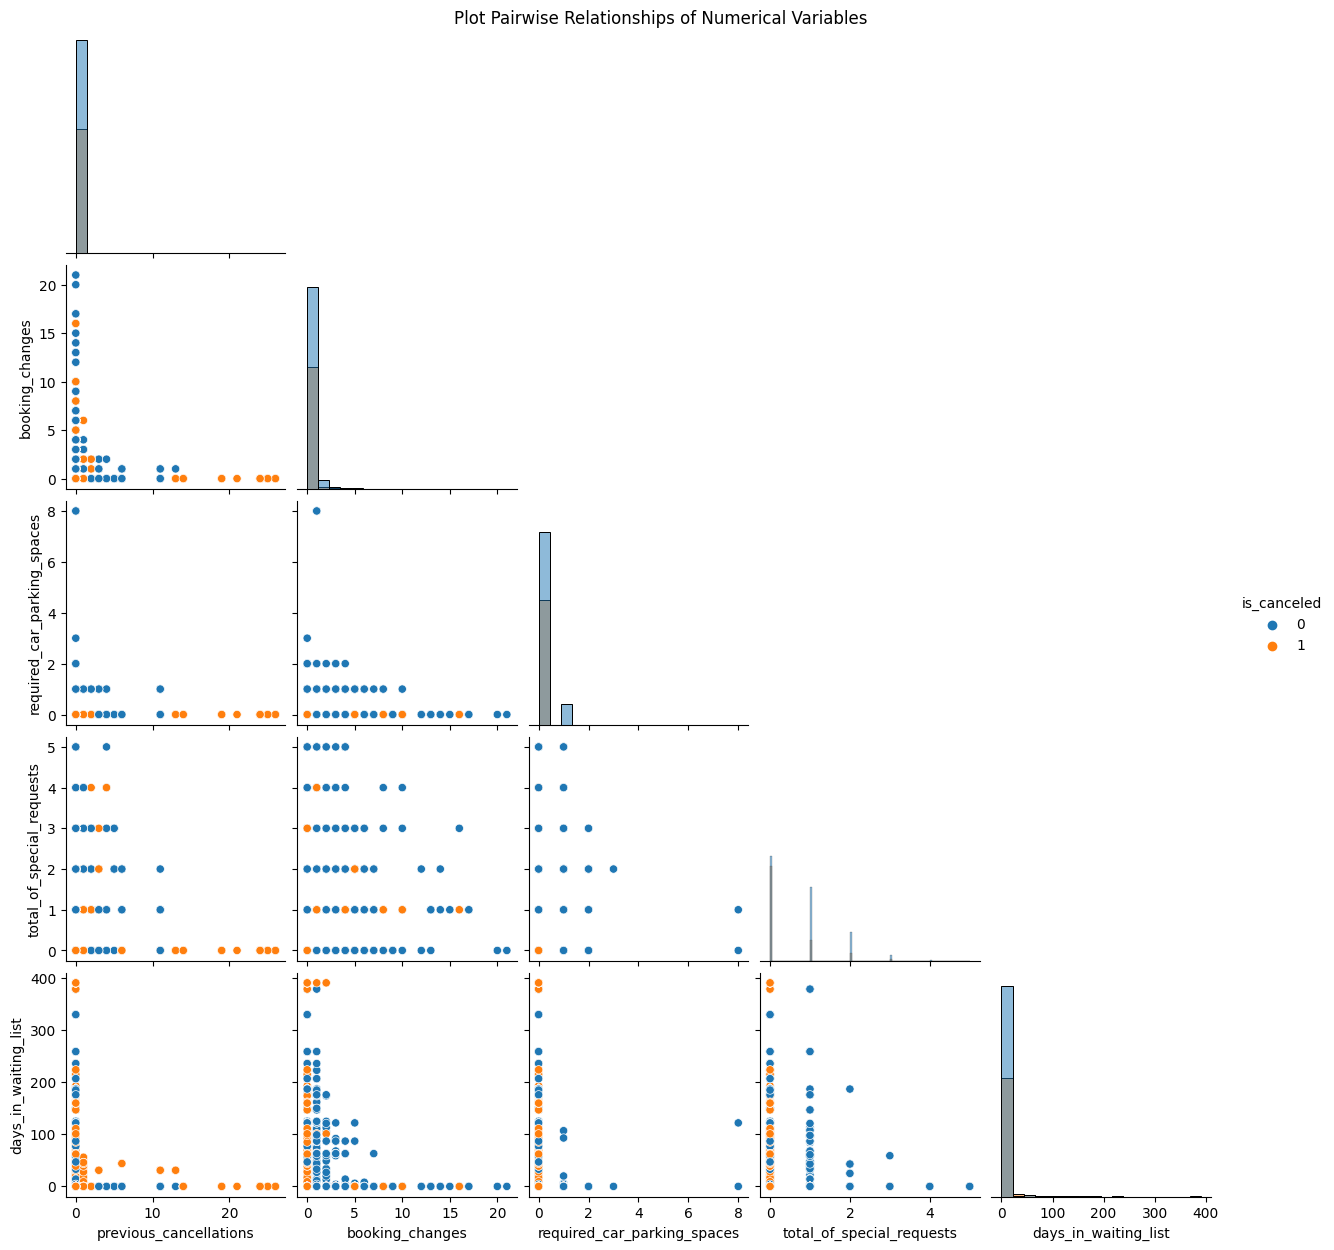

In [7]:
num_cols1 = ['previous_cancellations', 'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests', 'days_in_waiting_list', 'is_canceled']

grph = sns.pairplot(data[num_cols1], corner=True, hue='is_canceled', diag_kind='hist')
grph.fig.suptitle("Plot Pairwise Relationships of Numerical Variables", y=1)
plt.show()

**_Insight_:**
- Pada semua kolom discrete variable, nilai 0 mendominasi daripada nilai lainnya. Untuk penanganan selanjutnya akan dilakukan **diskritisasi**.
- Terdapat bivaraite outlier pada kolom required_car_parking_spaces, ada customer yang meminta 8 parking spaces pada 0 hari waiting list dan 100 hari lebih waiting list (belum dikonfirmasi oleh pihak hotel).
- Kolom **booking_changes nantinya tidak dipakai dalam proses modelling**, karena hal ini tidak sesuai jika nantinya model di-deploy, karena pada saat data masuk, pasti pelanggan tidak melakukan perubahan booking.

### 2️⃣ Categorical Variable

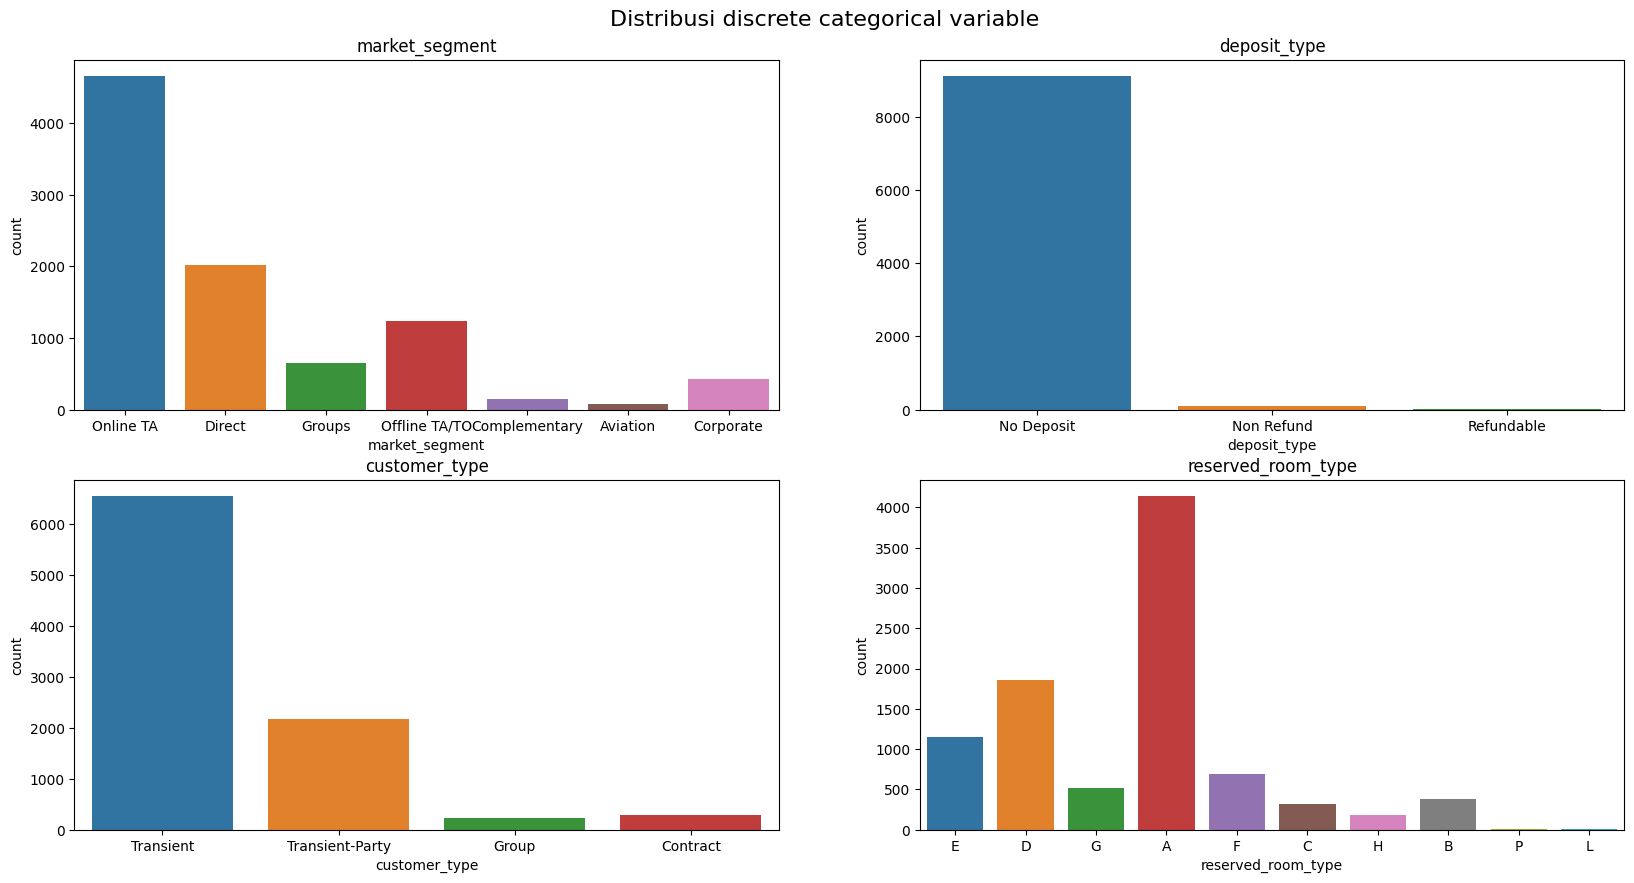

In [81]:
categ_kolom = ['market_segment', 'deposit_type', 'customer_type', 'reserved_room_type']

fnk.countplots_custom(data, categ_kolom, rows=2, cols=2, suptitle="Distribusi discrete categorical variable", size=(20,10))

**_Insight_:**
- Ada beberapa kategori di setiap kolomnya yang mendominasi dan ada beberapa kategori yang bersifat minoritas atau proporsinya data sedikit.
- Pada kolom market_segment, kategori yang mendominasi adalah Online TA. Hal ini berarti customer yang melakukan pesanan secara online travel agent.
- Pada kolom deposit_type, kategori yang mendominasi adalah No Deposit, customer banyak yang tidak melakukan deposit terlebih dahulu
- Pada kolom customer_type, customer yang melakukan pesanan yang bukan bagian dari grup atau kontrak lebih banyak daripada yang lain
- Banyak customer yang memesan dengan tipe room A.

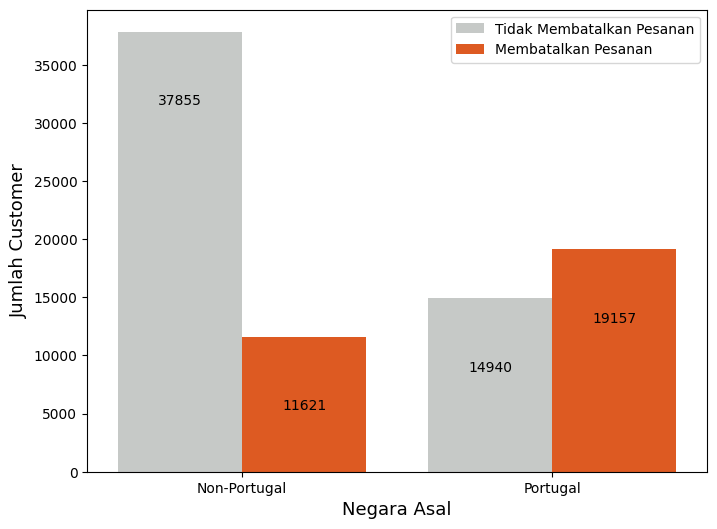

In [69]:
def country(df):
    if df['country'] == 'PRT':
        return "Portugal"
    else:
        return "Non-Portugal"

# DataFrame sementara untuk plot kolom country   
df_categ = data.copy()
df_categ['country'] = df_categ.apply(country, axis=1)

# figsize
plt.figure(figsize=(8,6))



# sns.countplot(df_categ, x='country');

country_plot = sns.countplot(
    data=df_categ, 
    x="country",
    hue='is_canceled',
    palette=['#C5C9C7', '#fc4e03']
)

# annotation
for bar in country_plot.patches:
    country_plot.annotate(
        format(bar.get_height(), '.0f'), (bar.get_x() + bar.get_width() / 2, bar.get_height() + 2), 
        ha='center', 
        va='center',
        size=10, 
        xytext=(0, -50),
        textcoords='offset points')

# x dan y label
plt.xlabel("Negara Asal", loc='center', size=13)
plt.ylabel("Jumlah Customer", loc='center', size=13)

# legend
country_plot.legend(['Tidak Membatalkan Pesanan', 'Membatalkan Pesanan'], loc='upper right')

# show
plt.show()

**_Insight_:**
- Jumlah customer yang negara asalnya bukan dari Portugal dan tidak membatalkan pesanan lebih banyak daripada customer dengan negara asalnya Portugal
- Jumlah customer yang negara asalnya dari Portugal dan membatalkan pesanan lebih banyak daripada customer dengan negara asalnya bukan dari Portugal
<br>
**TETAPI**,
- kolom `country` ini merupakan asal negara pemesan, jika ini dipertimbangkan dalam pemodelan, hal ini tentu akan bersifat **subjektif**. Negara asal dalam hal ini bukan negara tempat di mana customer berdomisili. Jadi, mungkin saja customer dengan country "A", tapi tidak berdomisili di country "A" tersebut.

### Cek Imbalance Data

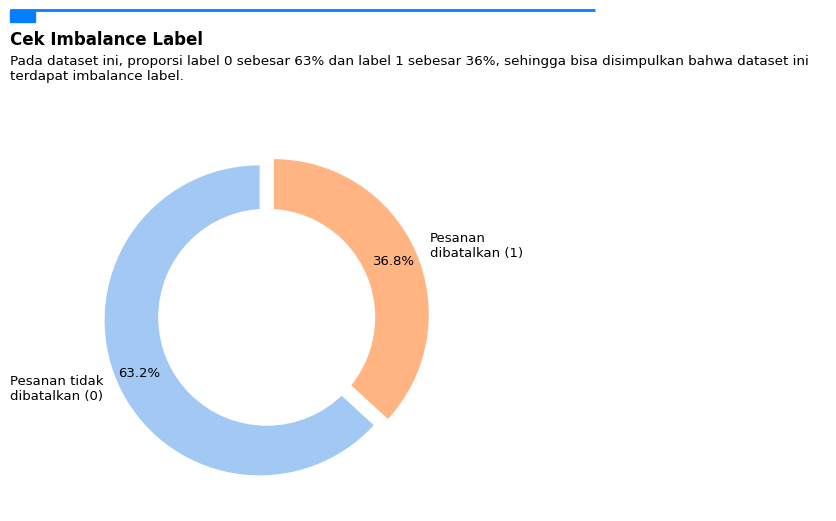

In [18]:
# DataFrame
temp_df = data['is_canceled'].value_counts(normalize=True) * 100

# initialize plot
fig, ax = plt.subplots(figsize=(5, 5))

# adjust the subplot so that the title would fit
plt.subplots_adjust(top=0.9)

# add line and rectangle on top.
fig.add_artist(lines.Line2D([0, 1.17], [1.12, 1.12], lw=2, color='#057eff', solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 1.095), 0.05, 0.025, color='#057eff'))

# add title
fig.text(
    0, 1.05, "Cek Imbalance Label", 
    fontsize=12,
    fontweight="bold", 
)

# add subtitle
fig.text(
    0, 0.98, 
    "Pada dataset ini, proporsi label 0 sebesar 63% dan label 1 sebesar 36%, sehingga bisa disimpulkan bahwa dataset ini\
    \nterdapat imbalance label.",
    fontsize=9.7, 
    color='black'
)
# create pie chart
plt.pie(x=[temp_df.loc[0], temp_df.loc[1]], 
        colors=sns.color_palette('pastel'),
        labels=['Pesanan tidak\ndibatalkan (0)', 'Pesanan\ndibatalkan (1)'], 
        autopct='%1.1f%%', 
        startangle=90, 
        pctdistance=0.85, 
        explode=(0.05, 0.05),
        textprops = {"fontsize": 9.5},
)

# create a circle at the center of the plot
fig = plt.gcf()
fig.gca().add_artist(plt.Circle((0, 0), 0.7, fc='white'));

**_Insight_**:
- Terdapat imbalance label pada dataset ini, sehingga salah satu cara untuk mengatasi hal ini dengan menggunakan metric evaluasi yang robust terhadap imbalance dataset. Dalam hal ini saya menggunakan metric evaluasi **MCC (Matthew Correlation Coefficient)**.
- Cancellation rate pada dataset ini sebesar 36% atau bisa dikatakan bahwa **4 dari 10 pesanan dibatalkan**. Berdasarkan jurnal pada problem statement, hal ini berpengaruh negatif terhadap revenue hotel.

## `Data Preperation`

<h3><span style="color:#0ad0f7">Menambahkan kolom lead_time</span></h3>

In [3]:
# drop duplikat pada dataset asli berdasarkan dengan subset kolom yang sudah disediakan
data_full = pd.read_csv("../data/raw/hotel_bookings.csv")
data_full = data_full.drop_duplicates(subset=list(data.columns))

# proses merge untuk pengambilan kolom lead_time
data = pd.merge(data, data_full, on=list(data.columns), how='left')
data = data[['country', 'market_segment', 'previous_cancellations','booking_changes', 'deposit_type', 'days_in_waiting_list', 'customer_type', 'reserved_room_type', 'required_car_parking_spaces', 'total_of_special_requests', 'lead_time','is_canceled']]
data.shape

(83573, 12)

<h3><span style="color:#0ad0f7">Drop kolom country dan booking_changes</span></h3>

In [4]:
# membuat DataFrame untuk outlier detection tanoa kolom country dan booking changes, 
# karena kedua kolom tersebut nantinya tidak dipakai

# drop kolom country
data = data.drop(columns=['country', 'booking_changes'], axis=1)
data.shape

(83573, 10)

<h3><span style="color:#0ad0f7">Drop Duplikat Data</span></h3>

In [5]:
# drop duplikat data
data = data.drop_duplicates(keep='last', ignore_index=True)
data.shape

(8084, 10)

<h3><span style="color:#0ad0f7">Outlier Detection</span></h3>

An outlier is a data point that is significantly different from the remaining data. ([Referensi](https://charuaggarwal.net/outlierbook.pdf))
- Outliers Detection Method: **Multivariate Detection** menggunakan algoritma DBSCAN. Karena pada pairplot yang telah dilakukan pada Data Understanding, dapat disimpulkan bahwa terdapat multivariate outlier.
- DBSCAN termasuk kedalam algoritma clustering, dimana hasil prediksinya berupa cluster-cluster dan jika didalam dataset kita terdapat noise/outlier maka cluster noise/outlier tersebut akan dilabeli dengan **-1**.
- Handling Outliers: **Remove from the dataset**. Outlier dapat mengakibatkan bias interpretasi dalam pembuatan model machine learning. Walaupun ada beberapa model yang **robust** terhadap outlier seperti model-model yang berbasis **Tree**, tetapi agar lebih **fair** dalam melakukan benchmark model nantinya, saya akan menghapus outliers dari dataset.
- Metric evaluasi yang akan digunakan untuk clustering adalah **silhouette_score** dan **calinski_harabasz_score**.

In [7]:
# from pycaret.internal.preprocess.transformers import TransformerWrapper

# DataFrame copy
data_out = data.copy()

# rescalling lead_time and prev_cancel_ratio
rs = StandardScaler()
data_out['lead_time'] = rs.fit_transform(data_out[['lead_time']])

# encoder categorical column
be = ce.BinaryEncoder(cols=['market_segment', 'reserved_room_type'])
be.fit(data_out)
data_out = be.transform(data_out)

onehot = ce.one_hot.OneHotEncoder(cols=['customer_type', 'deposit_type'])
onehot.fit(data_out[['customer_type', 'deposit_type']])
data_out = onehot.fit_transform(data_out)

# encoder month column
# data_out['arrival_date_month'] = data_out['arrival_date_month'].map({'January': 1, 'February': 2, 'March': 3, 'April': 4,
#                                                            'May': 5, 'June': 6, 'July' : 7, 'August' : 8, 'September' : 9, 'October' : 10, 'November' : 11, 'December' : 12})

# display DataFrame setelah dilakukan transform
# data_out = data_out.astype('int64')

# transformer = ColumnTransformer([
#     ('binaryencod', ce.BinaryEncoder(), ['market_segment', 'reserved_room_type']),
#     ('onehot', OneHotEncoder(), ['customer_type', 'deposit_type']),
#     ('scaller', StandardScaler(), ['lead_time'])
#     ], remainder='passthrough')

# fitting and transforming
# data_out = pd.DataFrame(transformer.fit_transform(data_out), columns=transformer.get_feature_names_out())
data_out = data_out.astype(int)
data_out.sample(10)

,market_segment_0,market_segment_1,market_segment_2,market_segment_3,previous_cancellations,deposit_type_1,deposit_type_2,deposit_type_3,days_in_waiting_list,customer_type_1,...,customer_type_3,customer_type_4,reserved_room_type_0,reserved_room_type_1,reserved_room_type_2,reserved_room_type_3,required_car_parking_spaces,total_of_special_requests,lead_time,is_canceled
6210,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0
4316,0,0,1,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,4,0,0
4449,0,0,1,0,0,1,0,0,0,1,...,0,0,0,1,0,0,0,3,-1,0
4223,0,1,1,0,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
4229,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,1,1,1,1,0,0
3043,0,0,0,1,0,1,0,0,0,1,...,0,0,0,1,1,0,1,2,0,0
457,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,1,3,0
4222,0,0,1,0,0,1,0,0,0,0,...,0,1,0,1,0,0,0,2,0,1
7903,0,0,1,0,0,1,0,0,0,1,...,0,0,0,1,0,1,0,3,0,0
5042,0,0,1,0,0,1,0,0,0,1,...,0,0,0,1,0,0,0,4,1,0


In [117]:
from tqdm import tqdm

# metric evaluation
silhouette = []
calinski_harabasz = []

# min sample, epsilon, dan jumlah cluster yang dihasilkan
n_sample = []
n_eps = []
n_cluster = []

for i in tqdm(np.arange(1, 100, 5)):
    try:
        for j in np.arange(0.1, 2, 0.1):
            # fit and predict
            model = DBSCAN(min_samples=i, eps=round(j, 2))
            model = model.fit_predict(data_out)

            # append nilai silhouette score dan calinski_harabasz_score
            silhouette.append(silhouette_score(data_out, model, random_state=22))
            calinski_harabasz.append(calinski_harabasz_score(data_out, model))

            # append nilai sample dan nilai epsilon
            n_sample.append(i)
            n_eps.append(round(j, 2))

            # jumlah cluster
            n_cluster.append(len(set(model)))
    except:
        print("Hanya ada 1 cluster, silhoutte score tidak bisa melakukan perhitungannya")
        break
        

# DataFrame
# pd.set_option('display.max_rows', 500)
df_score = pd.DataFrame(
    {
        'min_sample' : n_sample,
        'epsilon' : n_eps,
        'n_cluster' : n_cluster,
        'silhouette_score' : silhouette,
        'calinski_harabasz_score' : calinski_harabasz
    }
)
display(df_score)

# return max silhouette score dan calinski_harabasz_score
print(f"Maximum silhouette_score adalah dengan min sample {n_sample[silhouette.index(max(silhouette))]}, epsilon {n_eps[silhouette.index(max(silhouette))]}, dan {n_cluster[silhouette.index(max(silhouette))]} cluster --> silhouette_score : {max(silhouette)}")
print(f"Maximum calinski_harabasz_score adalah dengan min sample {n_sample[calinski_harabasz.index(max(calinski_harabasz))]}, epsilon {n_eps[calinski_harabasz.index(max(calinski_harabasz))]}, dan {n_cluster[calinski_harabasz.index(max(calinski_harabasz))]} cluster --> calinski_harabasz_score : {max(calinski_harabasz)}")

 90%|█████████ | 18/20 [07:05<00:47, 23.62s/it]

Hanya ada 1 cluster, silhoutte score tidak bisa melakukan perhitungannya


,min_sample,epsilon,n_cluster,silhouette_score,calinski_harabasz_score
0,1,0.1,2250,0.833003,1.000000
1,1,0.2,2250,0.833003,1.000000
2,1,0.3,2250,0.833003,1.000000
3,1,0.4,2250,0.833003,1.000000
4,1,0.5,2250,0.833003,1.000000
5,1,0.6,2250,0.833003,1.000000
6,1,0.7,2250,0.833003,1.000000
7,1,0.8,2250,0.833003,1.000000
8,1,0.9,2250,0.833003,1.000000
9,1,1.0,409,-0.173258,2793.227390


Maximum silhouette_score adalah dengan min sample 11, epsilon 1.8, dan 2 cluster --> silhouette_score : 0.9104820313922805
Maximum calinski_harabasz_score adalah dengan min sample 11, epsilon 1.8, dan 2 cluster --> calinski_harabasz_score : 6860.546453974251


In [168]:
# save into csv file
# df_score.to_csv(r"C:\Users\ASUS\Desktop\DataSciencePurwadhika\Modul3\Hotel-Booking-Demand\data\processed\dbscan_score2.csv", index=False)

In [71]:
from tqdm import tqdm
# metric evaluation
silhouette1 = []
calinski_harabasz1 = []

# min sample, epsilon, dan jumlah cluster
n_sample1 = []
n_eps1 = []
n_cluster1 = []

for k in tqdm([1, 116]):
    try:
        for h in np.arange(0.1, 2.9, 0.1):
            # fit and predict
            model1 = DBSCAN(min_samples=k, eps=round(h, 2))
            model1 = model1.fit_predict(data_out)

            # append nilai silhouette score dan calinski_harabasz_score
            silhouette1.append(silhouette_score(data_out, model1))
            calinski_harabasz1.append(calinski_harabasz_score(data_out, model1))

            # append nilai sample dan nilai epsilon
            n_sample1.append(k)
            n_eps1.append(round(h, 2))

            # jumlah cluster
            n_cluster1.append(len(set(model1)))
    except:
        print("Proses iterasi berhenti. Hanya ada 1 cluster, silhoutte score tidak bisa melakukan perhitungannya")
        break

# DataFrame
df_score1 = pd.DataFrame(
    {
        'min_sample1' : n_sample1,
        'epsilon1' : n_eps1,
        'n_cluster' : n_cluster1,
        'silhouette_score1' : silhouette1,
        'calinski_harabasz_score1' : calinski_harabasz1
    }
)
display(df_score1)

# return max silhouette score dan calinski_harabasz_score
print(f"Maximum silhouette_score adalah dengan min sample {n_sample1[silhouette1.index(max(silhouette1))]}, epsilon {n_eps1[silhouette1.index(max(silhouette1))]}, dan {n_cluster1[silhouette.index(max(silhouette1))]} clusters --> silhouette_score : {max(silhouette1)}")
print(f"Maximum calinski_harabasz_score adalah dengan min sample {n_sample1[calinski_harabasz1.index(max(calinski_harabasz1))]}, epsilon {n_eps1[calinski_harabasz1.index(max(calinski_harabasz1))]}, dan {n_cluster1[calinski_harabasz1.index(max(calinski_harabasz1))]} clusters --> calinski_harabasz_score : {max(calinski_harabasz1)}")

100%|██████████| 2/2 [00:57<00:00, 28.72s/it]


,min_sample1,epsilon1,n_cluster,silhouette_score1,calinski_harabasz_score1
0,1,0.1,1104,0.934761,1.000000
1,1,0.2,1104,0.934761,1.000000
2,1,0.3,1104,0.934761,1.000000
3,1,0.4,1104,0.934761,1.000000
4,1,0.5,1104,0.934761,1.000000
5,1,0.6,1104,0.934761,1.000000
6,1,0.7,1104,0.934761,1.000000
7,1,0.8,1104,0.934761,1.000000
8,1,0.9,1104,0.934761,1.000000
9,1,1.0,69,0.042165,63.100554


Maximum silhouette_score adalah dengan min sample 1, epsilon 0.1, dan 1104 clusters --> silhouette_score : 0.9347605959785911
Maximum calinski_harabasz_score adalah dengan min sample 116, epsilon 1.0, dan 5 clusters --> calinski_harabasz_score : 575.8021349509538


**_Insight_:**
- `Sweet spot` untuk nilai parameter minimum sample dan epsilon berada diangka **minimum sample 11 dan epsilon 1.8** karena pada angka tersebut menghasilkan **silhouette_score sebesar 0.91 dan calinski_harabasz_score sebesar 6860.55**.
- Nilai parameter tersebut akan digunakan untuk memprediksi bagaimana sebasaran data pada dataset ini.

In [87]:
# save into csv file
# df_score1.to_csv(r"C:\Users\faisa\Desktop\DataSciencePurwadhika\Modul3ML\HotelBookingDemand\data\processed\dbscan_score1.csv")

In [8]:
model = DBSCAN(min_samples=11, eps=1.8)
model.fit(data_out)
cluster = model.labels_

# DataFrame dengan Cluster
data_out['Cluster'] = cluster
display(data_out.sample(10))

# Jumlah cluster dan jumlah outlier
print(f"Jumlah cluster berdasarkan algoritma DBSCAN sebanyak {data_out.Cluster.nunique()} cluster")

# Percentage jumlah outlier
print(f"Jumlah data yang outlier sebanyak {data_out.Cluster.value_counts()[-1]} baris atau {round((data_out.Cluster.value_counts(normalize=True) * 100).values[1],2)}%")

,market_segment_0,market_segment_1,market_segment_2,market_segment_3,previous_cancellations,deposit_type_1,deposit_type_2,deposit_type_3,days_in_waiting_list,customer_type_1,...,customer_type_4,reserved_room_type_0,reserved_room_type_1,reserved_room_type_2,reserved_room_type_3,required_car_parking_spaces,total_of_special_requests,lead_time,is_canceled,Cluster
1831,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,1,0,2,0,0,0
3376,0,0,1,0,1,1,0,0,0,1,...,0,0,1,1,1,0,0,0,1,0
2963,0,1,0,0,0,1,0,0,122,0,...,0,0,1,0,0,0,0,0,1,-1
3080,0,0,1,0,0,1,0,0,0,1,...,0,0,1,1,1,0,0,0,0,0
7532,0,0,1,1,0,1,0,0,224,0,...,0,0,1,0,0,0,0,1,1,-1
4026,0,0,1,0,1,1,0,0,0,1,...,0,0,1,0,0,0,0,1,1,0
6091,0,0,1,0,0,1,0,0,0,1,...,0,0,0,1,0,0,3,0,0,0
6917,0,0,1,0,0,1,0,0,0,0,...,1,0,1,0,0,0,1,0,0,0
4823,0,0,1,0,0,1,0,0,0,1,...,0,0,0,1,0,0,3,0,0,0
4979,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,1,2,0,0,0


Jumlah cluster berdasarkan algoritma DBSCAN sebanyak 2 cluster
Jumlah data yang outlier sebanyak 367 baris atau 4.54%


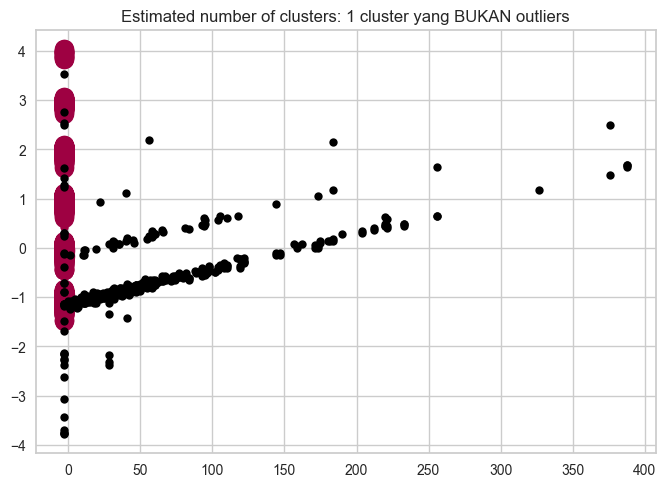

In [132]:
# visualisasi plot cluster menggunakan 2D PCA

# PCA estimator with 2 PC
pca = PCA(n_components=2, random_state=22, svd_solver='full')
pca.fit(data_out)
data_norm = pca.transform(data_out)

# jumlah cluster yang bukan outlier
n_clusters_ = len(set(cluster)) - (1 if -1 in cluster else 0)

# jumlah unique cluster
unique_labels = set(cluster)
core_samples_mask = np.zeros_like(cluster, dtype=bool)
core_samples_mask[model.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = cluster == k

    xy = data_norm[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = data_norm[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_} cluster yang BUKAN outliers")
plt.show()

In [133]:
# plot using 3D PCA
pca = PCA(n_components=3, random_state=22, svd_solver='full') 
data_encoded_pca = pca.fit_transform(data_out)

# DataFrame untuk plot
df_plot = pd.DataFrame(data_encoded_pca, columns=['PC1', 'PC2', 'PC3'])
df_plot['Cluster'] = cluster

fig = px.scatter_3d(data_frame=df_plot, x='PC1', y='PC2', z='PC3',
            color='Cluster', color_continuous_scale=px.colors.sequential.Hot, title='3D outlier plot')
fig.show();

In [9]:
# remove outliers
data['Cluster'] = cluster
data = data.query("~(Cluster == -1)")

# drop cluster column
data = data.drop(columns='Cluster')
data.shape

(7717, 10)

<h3><span style="color:#0ad0f7">Rare Value Detection</span></h3>
<h5>1️⃣ Numerical Variable <h5>

#### **Handling: Diskritisasi**

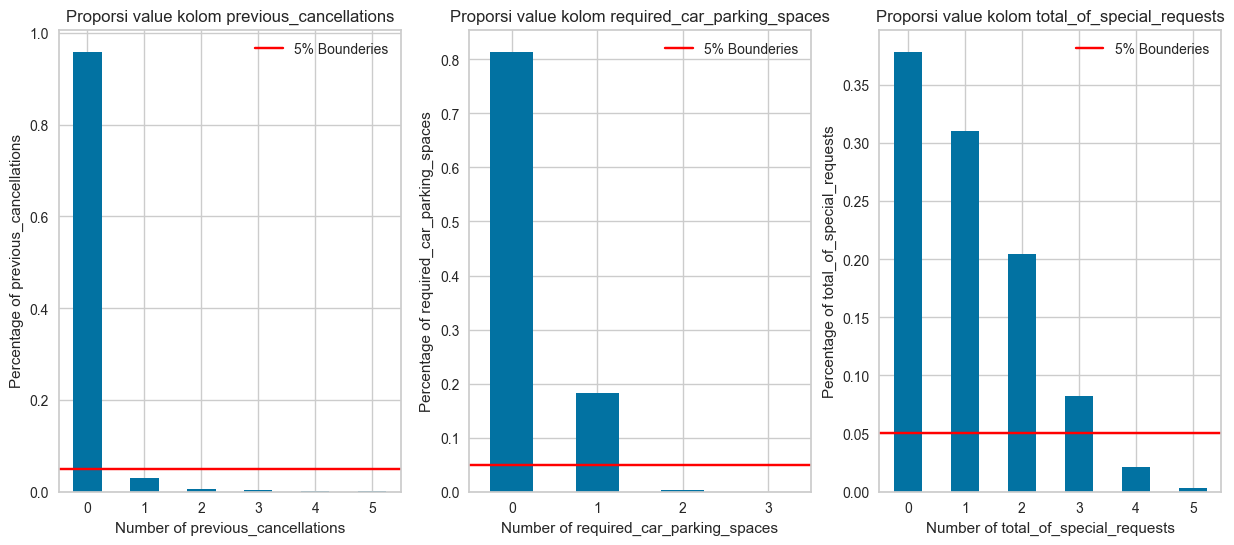

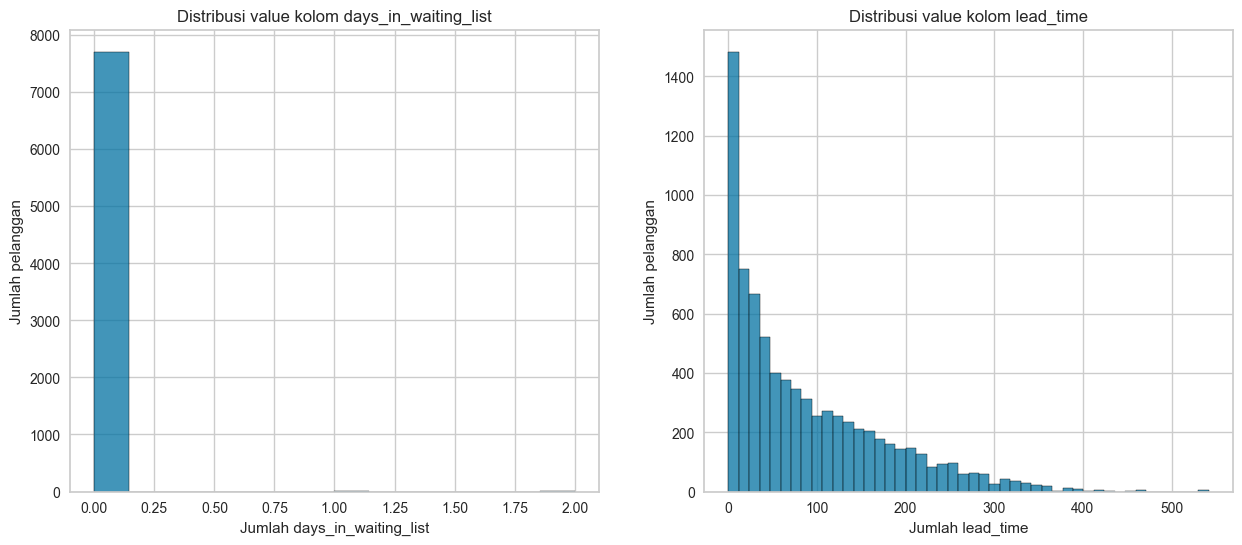

In [122]:
# kolom 'previous_cancellations', 'required_car_parking_spaces', 'total_of_special_requests'
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,6))

row1 = [ax1,ax2, ax3]
col1 = ['previous_cancellations', 'required_car_parking_spaces', 'total_of_special_requests']
title1 = ['Proporsi value kolom previous_cancellations','Proporsi value kolom required_car_parking_spaces', 'Proporsi value kolom total_of_special_requests']

for i in zip(row1, col1, title1):
    # DataFrame
    temp_df1 = pd.Series(data[i[1]].value_counts() / len(data)).sort_values(ascending=False).plot(kind='bar', label='', ax=i[0])

    # set title
    i[0].set_title(i[-1])

    # horizontal line: boundary yang digunakan adalah 5%, di bawah 5% akan diasumsikan sebagai rare value
    i[0].axhline(y=0.05, color='red', label='5% Bounderies')

    # set x label and its rotation
    i[0].tick_params(axis='x', labelrotation=360)

    i[0].set_xlabel(f"Number of {i[1]}")

    # ylabel
    i[0].set_ylabel(f'Percentage of {i[1]}')

    # legend
    i[0].legend()

# Continuous Variables : 'days_in_waiting_list' and  'lead_time'
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

# set variables for plot
row = [ax1,ax2]
col = ['days_in_waiting_list', 'lead_time']
title = ['Distribusi value kolom days_in_waiting_list','Distribusi value kolom lead_time']

for j in zip(row, col, title):
    # DataFrame
    sns.histplot(data, x=j[1], ax=j[0])

    # set title
    j[0].set_title(j[-1])

    # set x label and its rotation
    j[0].tick_params(axis='x', labelrotation=360)
    j[0].set_xlabel(f"Jumlah {j[1]}")

    # set ylabel
    j[0].set_ylabel(f'Jumlah pelanggan')

In [10]:
# Diskritisasi Kolom Numerical
# didiskritisasi dengan apakah pernah melakukan cancel (1) atau tidak (0)        
data['previous_cancellations'] = data['previous_cancellations'].apply(lambda x: 1 if x >= 1 else 0)

# didiskritisasi dengan apakah melakukan request tambahan (1) atau tidak (0)
data['total_of_special_requests'] = data['total_of_special_requests'].apply(lambda x: 1 if x >= 1 else 0)

# didiskritisasi dengan apakah langsung dikonfirmasi oleh pihak hotel (1) atau tidak (0)
data['days_in_waiting_list'] = data['days_in_waiting_list'].apply(lambda x: 1 if x>=1 else 0)

# didiskritisasi dengan apakah meminta parkir mobil (1) atau tidak (0)
data['required_car_parking_spaces'] = data['required_car_parking_spaces'].apply(lambda x: 1 if x>=1 else 0)

**_Insight_**:
1. Boundary yang digunakan adalah untuk discrete variables **5%**, di bawah 5% akan diasumsikan sebagai **rare value**
2. Pada kolom **previous_cancellations** akan didiskrititasi dengan --> **pernah membatalkan pesanan sebelumnya (1) atau tidak pernah sama sekali (0)**
2. Pada kolom **required_car_parkiring_spaces** akan didiskrititasi dengan --> **tidak ada request parking spaces (0) dan ada request (1)**
3. Pada kolom **total_of_special_requests** akan didiskrititasi dengan --> **tidak ada request (0) dan ada minimal 1 request (1)** (example of request:twin bed, high floor, etc)
5. Pada kolom **days_in_waiting_list** akan didiskrititasi dengan --> **langsung dikonfirmasi oleh pihak hotel (0) atau tidak (1)**
6. Pada kolom **lead_time** distibusi datanya skewed ke kanan --> akan dilakukan re-scalling ulang ketika melakukan pemodelan

<h5>2️⃣ Categorical Variable</h5>

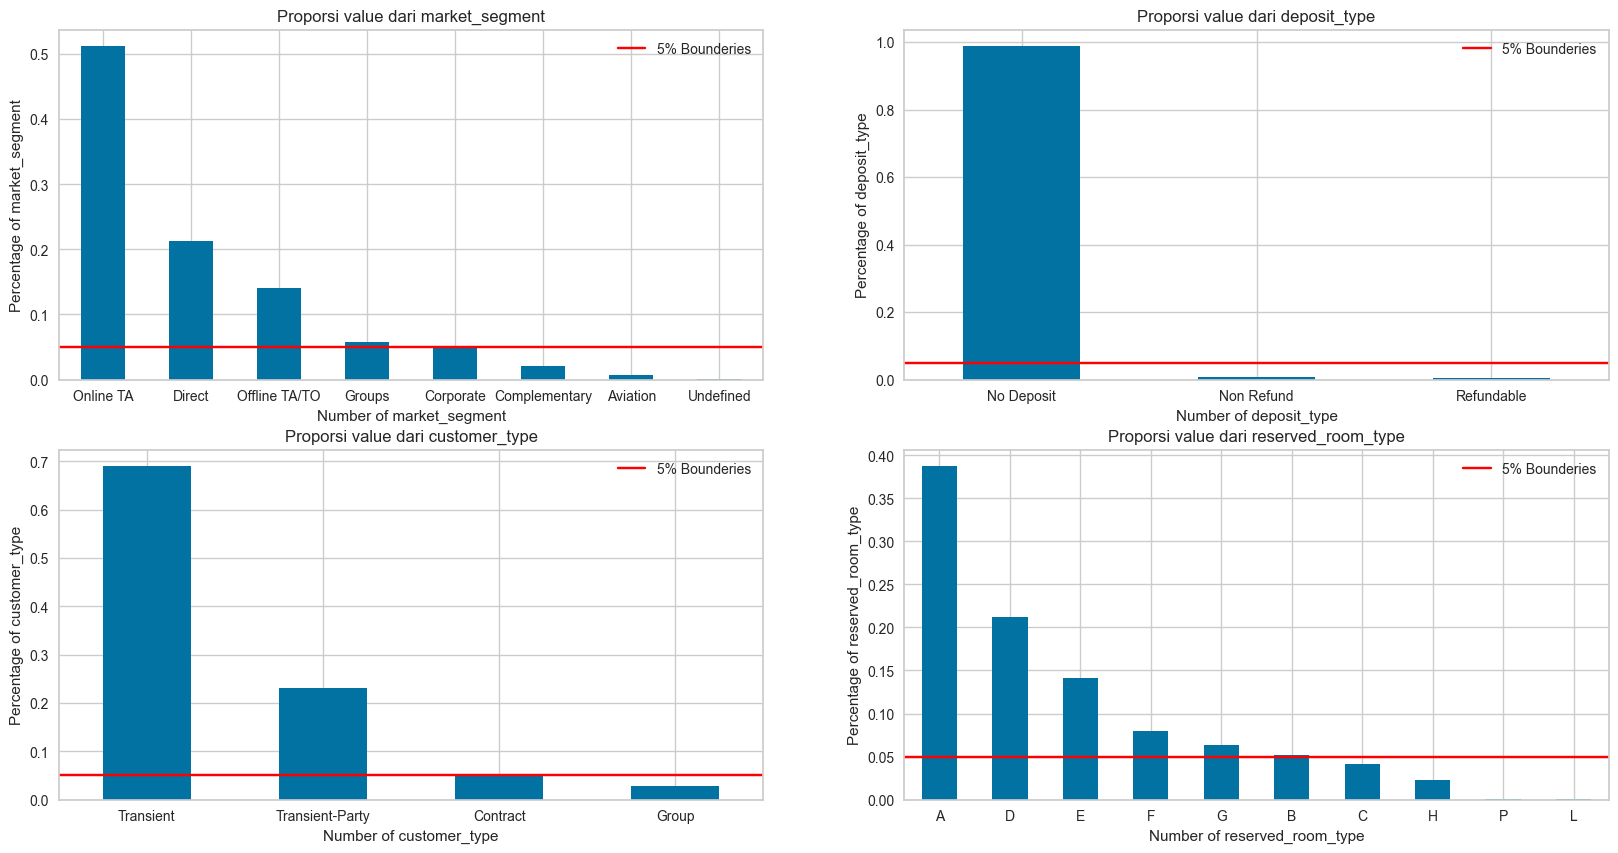

In [123]:
# kolom 'market_segment', 'deposit_type', 'customer_type', 'reserved_room_type'
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

row1 = [ax1,ax2]
row2 = [ax3,ax4]
col1 = ['market_segment', 'deposit_type']
col2 = ['customer_type', 'reserved_room_type']
title1 = ['Proporsi value dari market_segment','Proporsi value dari deposit_type']
title2 = ['Proporsi value dari customer_type','Proporsi value dari reserved_room_type']

for i in zip(row1, row2, col1, col2, title1, title2):
    # DataFrame
    temp_df1 = pd.Series(data[i[2]].value_counts() / len(data)).sort_values(ascending=False).plot(kind='bar', label='', ax=i[0])
    temp_df2 = pd.Series(data[i[3]].value_counts() / len(data)).sort_values(ascending=False).plot(kind='bar', label='', ax=i[1])
    # set title
    i[0].set_title(i[-2])
    i[1].set_title(i[-1])
    # horizontal line: boundary yang digunakan adalah 5%, di bawah 5% akan diasumsikan sebagai rare value
    i[0].axhline(y=0.05, color='red', label='5% Bounderies')
    i[1].axhline(y=0.05, color='red', label='5% Bounderies')
    # set x label and its rotation
    i[0].tick_params(axis='x', labelrotation=360)
    i[1].tick_params(axis='x', labelrotation=360)
    i[0].set_xlabel(f"Number of {i[2]}")
    i[1].set_xlabel(f"Number of {i[3]}")
    # ylabel
    i[0].set_ylabel(f'Percentage of {i[2]}')
    i[1].set_ylabel(f'Percentage of {i[3]}')
    # legend
    i[0].legend()
    i[1].legend()

In [11]:
# Diskritisasi Kolom Categorical
# didiskritisasi dengan market_segment yang termasuk ke dalam complementary, aviation, undefined dan tidak termasuk ke dalam Online TA, Direct, Offline TA/TO, Groups, Corporate akan dimasukkan ke dalam kelompok "Others"
data['market_segment'] = data['market_segment'].apply(lambda x: 'Others' if x in ['Complementary', 'Aviation', 'Undefined'] and x not in ['Online TA', 'Direct', 'Offline TA/TO', 'Groups', 'Corporate'] else x)

# didiskritisasi dengan reserved_room_type yang termasuk ke dalam F, G, B, C, H, P, L dan tidak termasuk ke dalam A, D, E, akan kelompokkan dengan "Others"
data['reserved_room_type'] = data['reserved_room_type'].apply(lambda x: 'Others' if x in ['C', 'H', 'P', 'L'] and x not in ['A', 'D', 'E', 'F', 'G','B'] else x)

# didiskritisasi dengan customer_type yang termasuk ke dalam Contract, group dan tidak termasuk ke dalam transient & Transient-Party akan dikelompokkan dengan "Others"
# data['customer_type'] = data['customer_type'].apply(lambda x: 'Others' if x in ['Contract', 'Group'] and x not in ['Transient', 'Transient-Party'] else x)

**_Insight_**:
1. Pada kolom market_segment, dilakukan diskritisasi dengan mengganti value Complementary, Aviation, Undefined dengan "others".
2. Pada kolom reserved_room_type, dilakukan diskritisasi dengan mengganti value room C, H, P, dan L dengan "others".
3. Diskritisasi dilakukan dengan tujuan untuk mengurangi kardinalitas data.

In [12]:
# drop duplicat kolom setelah didiskritisasi (karena menurunkan cardinalitas, sehingga kemungkinan duplikat menjadi lebih besar, dan ternyata memang ada duplikat)
data = data.drop_duplicates(keep='last', ignore_index=True)
data.shape

(6951, 10)

## `Modelling`

In [13]:
# Membuat class untuk Preproccessing yang dimasukan ke dalam pipeline
class PreproccesDataset(BaseEstimator, TransformerMixin):
    def _init_(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Diskritisasi Kolom Numerical
        # didiskritisasi dengan apakah pernah melakukan cancel (1) atau tidak (0)        
        X['previous_cancellations'] = X['previous_cancellations'].apply(lambda x: 1 if x >= 1 else 0)

        # didiskritisasi dengan apakah melakukan request tambahan (1) atau tidak (0)
        X['total_of_special_requests'] = X['total_of_special_requests'].apply(lambda x: 1 if x >= 1 else 0)

        # didiskritisasi dengan apakah langsung dikonfirmasi oleh pihak hotel (1) atau tidak (0)
        X['days_in_waiting_list'] = X['days_in_waiting_list'].apply(lambda x: 1 if x>=1 else 0)

        # didiskritisasi dengan apakah meminta parkir mobil (1) atau tidak (0)
        X['required_car_parking_spaces'] = X['required_car_parking_spaces'].apply(lambda x: 1 if x>=1 else 0)


        # Diskritisasi Kolom Categorical
        # didiskritisasi dengan market_segment yang termasuk ke dalam complementary, aviation, undefined dan tidak termasuk ke dalam Online TA, Direct, Offline TA/TO, Groups, Corporate akan dimasukkan ke dalam kelompok "Others"
        X['market_segment'] = X['market_segment'].apply(lambda x: 'Others' if x in ['Complementary', 'Aviation', 'Undefined'] and x not in ['Online TA', 'Direct', 'Offline TA/TO', 'Groups', 'Corporate'] else x)

        # didiskritisasi dengan reserved_room_type yang termasuk ke dalam F, G, B, C, H, P, L dan tidak termasuk ke dalam A, D, E, akan kelompokkan dengan "Others"
        X['reserved_room_type'] = X['reserved_room_type'].apply(lambda x: 'Others' if x in ['C', 'H', 'P', 'L'] and x not in ['A', 'D', 'E', 'F', 'G','B'] else x)

        # didiskritisasi dengan customer_type yang termasuk ke dalam Contract, group dan tidak termasuk ke dalam transient & Transient-Party akan dikelompokkan dengan "Others"
        # X['customer_type'] = X['customer_type'].apply(lambda x: 'Others' if x in ['Contract', 'Group'] and x not in ['Transient', 'Transient-Party'] else x)

        return X.to_numpy()

In [14]:
# split train dan test
dfTrain, dfTest = train_test_split(data, test_size=0.2, random_state=22, stratify=data['is_canceled'])

display(dfTrain.shape, dfTest.shape)

(5560, 10)

(1391, 10)

In [15]:
# membuat custom pipeline untuk dimasukkan ke dalam setup pycaret
customePipeline =[
    ('preprocess', TransformerWrapper(include=[], transformer=PreproccesDataset())),
    ('onehot', TransformerWrapper(include=['customer_type', 'deposit_type'], transformer=ce.one_hot.OneHotEncoder())),
    ('binaryencod', TransformerWrapper(include=['market_segment', 'reserved_room_type'], transformer=ce.BinaryEncoder())),
    ('scaller', TransformerWrapper(include=['lead_time'], transformer=StandardScaler()))
    # ('polynomial', TransformerWrapper(include=['lead_time'], transformer=PolynomialFeatures(degree=2)))
]

In [16]:
# melakukan initial setup untuk proses modelling dengan pycaret
from pycaret.classification import *

cls = setup(
    # random_state
    session_id=2020,

    # define numerical variable dan categorical variable
    numeric_features=['previous_cancellations', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests','lead_time'],
    categorical_features=['market_segment', 'deposit_type','customer_type', 'reserved_room_type'],

    # data yang digunakan untuk membangun model, split data training dan validatiion validation
    data=dfTrain,
    train_size=0.8,
    target='is_canceled',

    # handling multicollinearity
    remove_multicollinearity=True,
    multicollinearity_threshold=0.8,

    # ignore_features=['total_of_special_requests', 'days_in_waiting_list', 'reserved_room_type', 'previous_cancellations'],

    # custom pipeline
    preprocess=False,
    custom_pipeline=customePipeline,
    custom_pipeline_position=0,

    # upload experiment ke dagshub
    log_experiment='dagshub',
    log_data=True,
    log_plots=True,
    experiment_name='hotel booking demand'
)

,Description,Value
0,Session id,2020
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(5560, 10)"
4,Transformed data shape,"(5560, 19)"
5,Transformed train set shape,"(4448, 19)"
6,Transformed test set shape,"(1112, 19)"
7,Numeric features,5
8,Categorical features,4


❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=eaac7808-3287-4739-9272-a47dd3d9f804&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=47105c5991f222bf8e3da08b50893d02a97b95caab900b0735c2128a22ee79eb




Repository initialized!

2023/08/08 21:30:54 INFO mlflow.tracking.fluent: Experiment with name 'hotel booking demand' does not exist. Creating a new experiment.


Uploading files (2) to "fnkhairudin/Hotel-Booking-Demand"...

Upload finished successfully!

In [17]:
# add balanced_accucary metric
from sklearn.metrics import balanced_accuracy_score, fbeta_score

add_metric(
    'balanced', 'Bal. Acc', balanced_accuracy_score, greater_is_better = True
           )

# remove beberapa metric evaluasi
remove_metric('F1')
remove_metric('Kappa')
remove_metric('MCC')

<h3><span style="color:#0ad0f7">Melakukan Benchmark Model</span></h3>

In [18]:
compare_models(include=['dt', 'lr', 'knn', 'ada', 'rf', 'gbc', 'xgboost', 'lightgbm'], sort='Bal. Acc')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:32:29
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Decision Tree Classifier


,Model,Accuracy,AUC,Recall,Prec.,Bal. Acc,TT (Sec)
lr,Logistic Regression,0.7682,0.8040,0.3333,0.6003,0.6273,3.2470
gbc,Gradient Boosting Classifier,0.7734,0.8060,0.3117,0.6366,0.6238,3.1160
lightgbm,Light Gradient Boosting Machine,0.7513,0.7863,0.3549,0.5360,0.6229,3.1340
ada,Ada Boost Classifier,0.7671,0.7981,0.3126,0.6034,0.6198,3.0780
xgboost,Extreme Gradient Boosting,0.7336,0.7711,0.3540,0.4830,0.6106,3.2450
knn,K Neighbors Classifier,0.7201,0.7120,0.3333,0.4500,0.5948,3.1260
rf,Random Forest Classifier,0.6830,0.6993,0.3636,0.3841,0.5795,3.1660
dt,Decision Tree Classifier,0.6742,0.5802,0.3566,0.3690,0.5713,3.3830


Processing:   0%|          | 0/37 [00:00<?, ?it/s]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2020, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Insight:
- Ada 3 top model berdasarkan nilai Balanced Accuracy, yaitu **Logistic Regression**, **Light Gradient Boosting Machine**, dan **Ada Boost Classifier** dengan balanced accuray sebesar **65.11%**, **63.96%**, dan **63.68%**.
- Selanjutnya 3 model tersebut akan dicoba dilakukan **hyperparameter tuning**.

<h3><span style="color:#0ad0f7">Melakukan Hyperparameter Tuning</span></h3>

1. Merubah **Probability Threshold** berdasarkan hasil dari masing-masing evaluate_model dan bisa juga dilakukan adjustment secara manual yang ditinjau dari nilai metric evaluasinya.
2. Melakukan **Hyperparameter Tuning** dengan search library scikit-learn dan menggunakan metode Randomizer (karena keterbatasan tools).

**A. Logistic Regression**
<br>
Model logistic regression bekerja berdasarkan sigmoid function. Peluang suksesnya suatu kejadian dinotasikan dengan P(Y = 1) = odd / (1 + odd), dengan odds = exp(B0 + B1x1 + … + BKxk). Odd merupakan rasio antara peluang gagal dan peluang sukses dalam kondisi tertentu. 
$$ f(x) = \frac{1}{1+e^{\beta_0 + \sum_{j=1}^p X_j \beta_j}}\tag{3} $$ 

**dimana**: 

- $f(x)$: target variable
- $X_j$: independent variable (features)
- $\beta_0: $ slope coefficient (gradien)
- $\beta_j: $ intercept terms (beta 0)

Hyperparameter Tuning:
1. `penalty` : penalty merupakan metode atau algoritma yang digunakan untuk mengurangi effect atau magnitude dari beberapa fitur. Beberapa metodenya adalah l1 (Lasso), L2 (Ridge), elasticnet (menerapkan L1 dan L2).
2. `solver` : suatu metode atau algoritma yang digunakan untuk mencari nilai gradiennya (slope). Beberapa algoritma solver: lbfgs, liblinear, newton-cg, newton-cholesky, sag, dan saga.
3. `C` : Nilai regularisasi cost function. Semakin besar nilai C artinya memberikan "bobot (weight)" lebih kepada data training dan begitu juga sebaliknya. Secara analogi, nilai C besar berarti "Trust this training data a lot", ketika nilai C kecil berarti "This data may not be fully representative of the real world data, so if it's telling you to make a parameter really large, don't listen to it"
4. `max_iter` : maksimum jumlah iterasi untuk solver.
Berdasarkan hasil evaluate_model best probability threshold-nya adalah 0.33, namun ketika saya melakukan adjusment secara manual, hasil terbaik yang didapatkan adalah 0.31.

In [181]:
lr = create_model('lr', return_train_score=True, cross_validation=False, probability_threshold=0.31)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Bal. Acc,F2
Test,0.7365,0.8159,0.7647,0.4955,0.6014,0.4177,0.4396,0.7457,0.6898
Train,0.7334,0.8089,0.7651,0.4922,0.5991,0.4131,0.4357,0.7437,0.6887


In [166]:
evaluate_model(lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
parameters = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga'],
    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
    'max_iter': [100, 150, 200, 250, 500, 1000],
}

tuned_model_lr = tune_model(
    lr, 
    optimize='Bal. Acc', 
    choose_better=True, 
    n_iter=50, 
    search_algorithm='random', 
    search_library='scikit-learn', 
    custom_grid=parameters,
    return_train_score=True
    )

**B. Gradient Boosting Classifier**
<br>
Secara general, cara kerja algoritma GBC hampir mirip dengan LightGBM, yang membedakan adalah pada GBM tidak ada pinalti yang digunakan. Pada LightBGM terdapat pinalti yang digunakan, yaitu reg_alpha dan reg_lambda. Untuk parameternya pun hampir sama dengan LightGMB.

Berdasarkan hasil evaluate_model best probability threshold-nya adalah 0.31, namun ketika saya melakukan adjusment secara manual, hasil terbaik yang didapatkan adalah 0.26.

In [210]:
gbc = create_model('gbc', return_train_score=True, cross_validation=False, probability_threshold=0.26)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Bal. Acc,F2
Test,0.7203,0.8328,0.8304,0.4781,0.6068,0.4133,0.4513,0.7561,0.7238
Train,0.7223,0.8374,0.8290,0.4807,0.6086,0.4161,0.4533,0.7569,0.7241


In [183]:
evaluate_model(gbc)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [215]:
parameters = {
    "n_estimators": [150,300,500,700],
    "max_depth": [1,3,5,7,9],
    "learning_rate": [round(i,2) for i in np.arange(0.05, 0.2, 0.01)],
    # 'min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
    # 'min_samples_leaf' : np.linspace(0.1, 0.5, 5, endpoint=True),
    'max_features' : list(range(1,get_config('X_train_transformed').shape[1] + 1)),
    'warm_start' : [True, False]
}

tuned_model_gbc = tune_model(
        gbc, 
        optimize='Bal. Acc', 
        choose_better=True, 
        n_iter=20, 
        search_algorithm='random', 
        search_library='scikit-learn', 
        custom_grid=parameters,
        return_train_score=True
)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


**C. Model Light Gradient Boosting Machine**
<br>
Pada dasarnya, Boosting basisnya adalah tree-based dimana tree berkembang secara sekuensial (iterasi) menyesuaikan dengan bobot (weight) sample yang terprediksi salah.
Beberapa parameter yang dilakukan hyperparameter untuk meningkatkan Balanced Accucary:
1. `learning_rate` : Sebesar besar kontribusi setiap tree dalam setiap iterasi. **Memperkecil learning_rate dan memperbesar jumlah iterasi** dapat meningkatkan score metric evaluasi.
9. `n_estimators` : Jumlah iterasi boosting.
2. `num_leaves` : jumlah maksimum leaf dalam pohon. Memperbesar num_leaves, namun hal ini dapat mengakibatkan overfitting.
3. `boosting_type` : jenis boosting yang digunakan: 'gbdt' ( Gradient Boosting Decision Tree), 'dart' (Dropouts meet Multiple Additive Regression Trees), 'rf' (Random Forest).
4. `max_depth` : jumlah maksimum dari setiap pohon.
6. `min_child_samples` : jumlah minimal data di satu leaf.
7. `reg_alpha` : Ini adalah parameter regulasi tipe L1 (Lasso). Regulasi digunakan untuk mencegah overfitting dengan menambahkan penalti pada koefisien model.
8. `reg_lamda` : Ini adalah parameter regulasi tipe L2 (Ridge). Seperti reg_alpha, regulasi ini bertujuan untuk mengontrol kompleksitas model. Ketika lebih tinggi akan memperkuat regulasi L2 dan mengurangi risiko overfitting.
9. `colsample_bytree` : berupa fraksi, nilainya 0 s/d 1. Jika 1 maka LightGBM akan menggunakan semua features yang tersedia. Contoh 0.8, maka kurang dari 1, maka LightBGM maka akan menggunakan 80% features yang tersedia. Berfungsi untuk mengcegah overfitting.

Referensi:
1. [Parameters Tuning LightGBM](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)
2. [Parameters](https://lightgbm.readthedocs.io/en/latest/Parameters.html)

Berdasarkan hasil evaluate_model best **probability threshold-nya** adalah **0.27**, namun ketika saya melakukan adjusment secara manual, hasil terbaik yang didapatkan adalah 0.35.

In [211]:
lightgbm = create_model('lightgbm', return_train_score=True, cross_validation=False, objective='binary', probability_threshold=0.28)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Bal. Acc,F2
Test,0.7149,0.8152,0.7647,0.4702,0.5823,0.3841,0.4103,0.7311,0.6796
Train,0.7866,0.9049,0.8981,0.5559,0.6867,0.5382,0.5738,0.8228,0.7996


In [153]:
evaluate_model(lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [216]:
parameters = {
    'learning_rate': [0.11, 0.12, 0.13, 0.14, 0.15],
    'n_estimators': [50, 100, 200, 300, 400],
    'num_leaves': [10, 20, 30, 31],
    'boosting_type' : ['gbdt', 'dart', 'rf'],
    'max_depth': [1,3,5,7,9],
    'min_child_samples': [10, 20, 30],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.0, 0.1, 0.5],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]


    # 'subsample': [0.8, 0.9, 1.0],
    # 'colsample_bytree': [0.8, 0.9, 1.0],
    # 'min_split_gain': [0.0, 0.1, 0.5],
    # 'subsample_freq': [0, 5, 10],
}

tuned_model_lightgbm = tune_model(
                lightgbm, 
                optimize='Bal. Acc', 
                choose_better=True, 
                n_iter=20, 
                search_algorithm='random', 
                search_library='scikit-learn', 
                custom_grid=parameters,
                return_train_score=True
                    )

Fitting 10 folds for each of 20 candidates, totalling 200 fits


---------
---------
---------

In [147]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [133]:
parameters = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [1,3,7,9],
    'min_samples_leaf': [20, 40, 60, 80, 100],
    'max_features': [i for i in range(1, get_config('X_train_transformed').shape[1] + 1)],
    'criterion' : ['gini', 'entropy', 'log_loss']
}

tuned_model_rf = tune_model(
    estimator=rf, 
    optimize='Bal. Acc', 
    n_iter=30, 
    custom_grid=parameters, 
    search_library='scikit-learn',
    search_algorithm='random',
    return_train_score=True
)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [134]:
print(tuned_model_rf)

CustomProbabilityThresholdClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None,
                                     classifier=RandomForestClassifier(bootstrap=True,
                                                                       ccp_alpha=0.0,
                                                                       class_weight=None,
                                                                       criterion='gini',
                                                                       max_depth=9,
                                                                       max_features=15,
                                                                       max_leaf_nodes=None,
                                                                       max_samples=None,
                                                                       min_impurity_decrease=0.0,
                                                                       mi

In [135]:
evaluate_model(tuned_model_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [104]:
xgboost = create_model('xgboost', return_train_score=True, cross_validation=False, probability_threshold=0.30)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Bal. Acc,F2
Test,0.7643,0.8360,0.6518,0.5030,0.5678,0.4095,0.4160,0.7256,0.6154
Train,0.8376,0.9250,0.8377,0.6166,0.7103,0.6011,0.6147,0.8376,0.7816


In [105]:
parameters = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0],
    'scale_pos_weight': [1, 2, 5, 10]
}

tuned_model = tune_model(
    estimator=xgboost, 
    optimize='Bal. Acc', 
    n_iter=30, 
    custom_grid=parameters, 
    search_library='scikit-learn',
    search_algorithm='random',
    return_train_score=True
)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [97]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [343]:
evaluate_model(rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [344]:
parameters = {
    'n_estimators': [10, 50, 100, 150, 200, 250, 300],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 80, 100],
    'max_features' : [10, 11, 12, 13, 14, 15, 16],
    'max_leaf_nodes' : [50, 75, 100, 125]
}

tuned_model = tune_model(
    estimator=rf, 
    optimize='MCC', 
    n_iter=20, 
    custom_grid=parameters, 
    search_library='scikit-learn',
    search_algorithm='random',
    return_train_score=True
)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [345]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [312]:
lightgbm = create_model('lightgbm', return_train_score=True, cross_validation=False, probability_threshold=0.22)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Bal. Acc,F2
Test,0.7178,0.7984,0.8789,0.4537,0.5985,0.4133,0.4672,0.7730,0.7402
Train,0.7437,0.8887,0.9371,0.4815,0.6362,0.4682,0.5302,0.8100,0.7880


In [313]:
evaluate_model(lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [314]:
parameters = {
    'num_leaves': [10, 20, 30, 31],
    'max_depth': [5, 10, 20, 30],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.0, 0.1, 0.5],
    'min_split_gain': [0.0, 0.1, 0.5],
    'subsample_freq': [0, 5, 10],
}

tuned_model = tune_model(lightgbm, 
                    optimize='F2', 
                    choose_better=True, 
                    n_iter=20, 
                    search_algorithm='random', 
                    search_library='scikit-learn', 
                    custom_grid=parameters,
                    return_train_score=True)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [ ]:
knn = create_model('knn', return_train_score=True, cross_validation=False)

In [226]:
lr = create_model('lr', return_train_score=True, cross_validation=False, probability_threshold=0.30)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Bal. Acc,F2
Test,0.7854,0.8568,0.8117,0.5339,0.6441,0.4997,0.5222,0.7944,0.7352
Train,0.7587,0.8419,0.8036,0.4972,0.6143,0.4526,0.4802,0.7741,0.7154


In [227]:
evaluate_model(lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [228]:
parameters = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga'],
    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
    'max_iter': [100, 150, 200, 250, 500, 1000],
    'class_weight' : ['None', 'balanced']
}

tuned_model = tune_model(lr, optimize='F2', choose_better=True, n_iter=30, search_algorithm='random', search_library='scikit-learn', custom_grid=parameters)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Bal. Acc,F2
Fold,,,,,,,,,
0,0.6381,0.8516,0.9213,0.3905,0.5485,0.3209,0.4044,0.7353,0.7244
1,0.6113,0.8211,0.9326,0.3739,0.5338,0.2929,0.3848,0.7216,0.7180
2,0.6488,0.8594,0.9663,0.4019,0.5677,0.3479,0.4444,0.7578,0.7544
3,0.6086,0.8264,0.9326,0.3722,0.5321,0.2898,0.3822,0.7198,0.7168
4,0.6542,0.8711,0.9888,0.4074,0.5770,0.3611,0.4645,0.7690,0.7692
5,0.6488,0.8431,0.9556,0.4038,0.5677,0.3457,0.4381,0.7534,0.7504
6,0.6640,0.8181,0.9213,0.4100,0.5675,0.3533,0.4316,0.7522,0.7374
7,0.6398,0.8511,0.9888,0.3982,0.5677,0.3439,0.4507,0.7594,0.7626
8,0.6290,0.8460,0.9438,0.3871,0.5490,0.3174,0.4101,0.7369,0.7330


Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [212]:
gbc = create_model('gbc', return_train_score=True, cross_validation=False, probability_threshold=0.31)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Bal. Acc,F2
Test,0.7790,0.8512,0.7892,0.5254,0.6308,0.4820,0.5023,0.7825,0.7172
Train,0.7678,0.8691,0.8159,0.5091,0.6270,0.4713,0.4989,0.7843,0.7282


In [213]:
evaluate_model(gbc)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [215]:
parameters = {
    "n_estimators":[150,300,500,700],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[round(i,2) for i in np.arange(0.05, 0.2, 0.01)],
    'min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
    'min_samples_leaf' : np.linspace(0.1, 0.5, 5, endpoint=True),
    'max_features' : list(range(1,get_config('X_train_transformed').shape[1]))
}

tuned_model = tune_model(gbc, optimize='F2', choose_better=True, n_iter=20, search_algorithm='random', search_library='scikit-learn', custom_grid=parameters)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Bal. Acc,F2
Fold,,,,,,,,,
0,0.7641,0.8214,0.7079,0.5040,0.5888,0.4299,0.4421,0.7448,0.6549
1,0.7105,0.7945,0.7191,0.4354,0.5424,0.3488,0.3723,0.7134,0.6362
2,0.7534,0.8268,0.7528,0.4891,0.5929,0.4272,0.4477,0.7532,0.6795
3,0.7399,0.8137,0.8090,0.4737,0.5975,0.4242,0.4574,0.7636,0.7087
4,0.7078,0.8045,0.6854,0.4296,0.5281,0.3323,0.3513,0.7001,0.6124
5,0.7641,0.8148,0.7556,0.5075,0.6071,0.4477,0.4658,0.7612,0.6883
6,0.7473,0.8060,0.6742,0.4800,0.5607,0.3904,0.4015,0.7222,0.6237
7,0.7661,0.8401,0.8090,0.5070,0.6234,0.4664,0.4932,0.7808,0.7229
8,0.7554,0.8150,0.7978,0.4931,0.6094,0.4454,0.4728,0.7699,0.7100


Fitting 10 folds for each of 20 candidates, totalling 200 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [105]:
evaluate_model(xgboost)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [177]:
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter' : ['best', 'random'],
    'min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
    'class_weight' : ['balanced', 'None']
}
tuned_model = tune_model(dt, optimize='MCC', choose_better=True, n_iter=10, search_algorithm='random', custom_grid=params)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Bal. Acc,F2
Fold,,,,,,,,,
0,0.4408,0.7258,0.8600,0.3554,0.5029,0.0700,0.1111,0.5476,0.6698
1,0.5329,0.7824,0.9000,0.4054,0.5590,0.1929,0.2678,0.6265,0.7235
2,0.4079,0.6367,0.8600,0.3413,0.4886,0.0334,0.0577,0.5231,0.6595
3,0.4967,0.7801,0.9388,0.3866,0.5476,0.1627,0.2556,0.6115,0.7302
4,0.4636,0.6626,0.9388,0.3710,0.5318,0.1245,0.2127,0.5870,0.7188
5,0.4570,0.6998,0.8776,0.3613,0.5119,0.0966,0.1517,0.5662,0.6825
6,0.4636,0.7526,0.9200,0.3740,0.5318,0.1152,0.1909,0.5788,0.7121
7,0.4570,0.7244,0.8800,0.3667,0.5176,0.0942,0.1486,0.5638,0.6875
8,0.5033,0.6928,1.0000,0.4000,0.5714,0.1867,0.3209,0.6287,0.7692


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [38]:
n_samples = 1111+563
n_classes = 2
n_samples0 = 1111
n_samples1 = 533

weight0 = n_samples / (n_classes*n_samples0)
weight1 = n_samples / (n_classes*n_samples1)
weight1

1.5703564727954973

In [15]:
parameters = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga'],
    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
    'max_iter': [100, 150, 200, 250, 500, 1000],
    'class_weight' : [{0:1.57, 1:0.75}, 'balanced']
}

tuned_model = tune_model(lr, optimize='MCC', choose_better=True, n_iter=30, search_algorithm='random', search_library='scikit-learn', custom_grid=parameters)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Bal. Acc,F2
Fold,,,,,,,,,
0,0.5755,0.8013,1.0000,0.4304,0.6018,0.2779,0.4017,0.6875,0.7907
1,0.6792,0.8815,1.0000,0.5072,0.6731,0.4181,0.5141,0.7606,0.8373
2,0.5905,0.7989,1.0000,0.4416,0.6126,0.2966,0.4173,0.6972,0.7981
3,0.6381,0.8413,1.0000,0.4722,0.6415,0.3600,0.4685,0.7324,0.8173
4,0.6381,0.8132,1.0000,0.4722,0.6415,0.3600,0.4685,0.7324,0.8173
5,0.5619,0.8248,1.0000,0.4250,0.5965,0.2603,0.3868,0.6761,0.7870
6,0.6667,0.8496,1.0000,0.4928,0.6602,0.3998,0.4998,0.7535,0.8293
7,0.6000,0.7862,0.8824,0.4412,0.5882,0.2754,0.3400,0.6736,0.7353
8,0.5714,0.8287,1.0000,0.4304,0.6018,0.2723,0.3970,0.6831,0.7907


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [164]:
TP = 75
FN = 10

TN = 156
FP = 21

MCC = (TP * TN - (FP * FN)) / np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
MCC

0.7420518840961695

In [44]:
ada = create_model('gbc', probability_threshold=0.49, return_train_score=True, cross_validation=False)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:22:45
Status,. . . . . . . . . . . . . . . . . .,Fitting Gradient Boosting Classifier
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Bal. Acc,F2
Test,0.7429,0.8127,0.4459,0.5946,0.5097,0.3402,0.3467,0.6579,0.4694
Train,0.7913,0.8766,0.4651,0.7407,0.5714,0.4429,0.4638,0.6978,0.5025


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [19]:
parameters = {
    "n_estimators":[150,300,500,700],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[round(i,2) for i in np.arange(0.05, 0.2, 0.01)],
    'min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
    'min_samples_leaf' : np.linspace(0.1, 0.5, 5, endpoint=True),
    'max_features' : list(range(1,get_config('X_train_transformed').shape[1]))
}

tuned_model = tune_model(best, optimize='MCC', choose_better=True, n_iter=10, search_algorithm='tpe', search_library='optuna', custom_grid=parameters)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:44:45
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Bal. Acc,F2
Fold,,,,,,,,,
0,0.7682,0.8429,0.4667,0.6562,0.5455,0.3958,0.4062,0.6814,0.4953
1,0.7815,0.8318,0.5111,0.6765,0.5823,0.4382,0.4460,0.7037,0.5374
2,0.7748,0.8342,0.5217,0.6667,0.5854,0.4340,0.4401,0.7037,0.5455
3,0.7933,0.8397,0.4889,0.7333,0.5867,0.4561,0.4728,0.7063,0.5238
4,0.7533,0.8439,0.4889,0.6111,0.5432,0.3771,0.3815,0.6778,0.5093
5,0.8000,0.8632,0.4667,0.7778,0.5833,0.4624,0.4885,0.7048,0.5072
6,0.7667,0.8035,0.4000,0.6923,0.5070,0.3682,0.3920,0.6619,0.4369
7,0.7600,0.8043,0.4889,0.6286,0.5500,0.3898,0.3956,0.6825,0.5116
8,0.7000,0.8068,0.3778,0.5000,0.4304,0.2321,0.2363,0.6079,0.3972


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

[I 2023-08-03 18:44:46,095] Searching the best hyperparameters using 1503 samples...
[I 2023-08-03 18:53:30,720] Finished hyperparemeter search!


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [13]:
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}
tuned_model = tune_model(best, optimize='MCC', choose_better=True, n_iter=5, search_algorithm='tpe', search_library='optuna')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7896,0.7666,0.1242,0.8636,0.2171,0.1680,0.2773
1,0.7911,0.7926,0.1569,0.7742,0.2609,0.1973,0.2843
2,0.7972,0.7393,0.1494,0.9583,0.2584,0.2079,0.3323
3,0.7911,0.7876,0.1429,0.8462,0.2444,0.1890,0.2926
4,0.7926,0.7638,0.1494,0.8519,0.2541,0.1975,0.3012
5,0.7834,0.7163,0.1169,0.7826,0.2034,0.1512,0.2459
6,0.8003,0.7832,0.1818,0.8750,0.3011,0.2391,0.3416
7,0.7865,0.7589,0.1169,0.8571,0.2057,0.1579,0.2666
8,0.7938,0.7450,0.1569,0.8276,0.2637,0.2040,0.3017


[I 2023-08-01 22:33:32,746] Searching the best hyperparameters using 6508 samples...
[I 2023-08-01 22:36:34,085] Finished hyperparemeter search!


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [30]:
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
tuned_model = tune_model(best, optimize='MCC', choose_better=True, n_iter=15, search_algorithm='random')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6790,0.7676,0.7516,0.4021,0.5239,0.3138,0.3488
1,0.6851,0.7824,0.7974,0.4122,0.5434,0.3384,0.3815
2,0.6498,0.7391,0.7403,0.3775,0.5000,0.2718,0.3085
3,0.6790,0.7802,0.7792,0.4068,0.5345,0.3246,0.3646
4,0.6866,0.7699,0.7727,0.4132,0.5385,0.3328,0.3702
5,0.6467,0.7381,0.6948,0.3690,0.4820,0.2503,0.2793
6,0.6636,0.7833,0.7338,0.3883,0.5079,0.2874,0.3211
7,0.6774,0.7609,0.7792,0.4054,0.5333,0.3225,0.3628
8,0.6538,0.7479,0.7190,0.3767,0.4944,0.2684,0.3009


Fitting 10 folds for each of 15 candidates, totalling 150 fits


In [20]:
parameters = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga'],
    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
    'max_iter': [100, 150, 200]
}

tuned_model = tune_model(best, optimize='MCC', choose_better=True, n_iter=15, search_algorithm='random')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:37:34
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6805,0.7783,0.7059,0.3985,0.5094,0.2988,0.3256
1,0.7081,0.8224,0.7908,0.4337,0.5602,0.3685,0.4058
2,0.7005,0.7731,0.7273,0.4226,0.5346,0.3359,0.3628
3,0.7005,0.8223,0.7987,0.4286,0.5578,0.3611,0.4012
4,0.7020,0.7945,0.7662,0.4275,0.5488,0.3521,0.3855
5,0.7235,0.7963,0.7857,0.4515,0.5735,0.3903,0.4231
6,0.7112,0.8026,0.7532,0.4361,0.5524,0.3609,0.3903
7,0.7250,0.7999,0.7403,0.4506,0.5602,0.3770,0.4016
8,0.7031,0.7874,0.7778,0.4281,0.5522,0.3569,0.3926


Fitting 10 folds for each of 15 candidates, totalling 150 fits


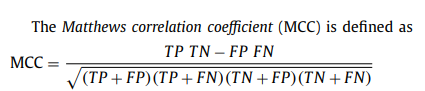

In [125]:
TP = 20
FN = 0

TN = 375
FP = 5

MCC = (TP * TN - (FP * FN)) / np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
MCC

0.8885233166386385